# Intermediate Exam
Student: Ana Carolina Souza <br>
<a href= "https://www.kaggle.com/datasets/rmisra/news-category-dataset">Dataset</a> <br>
<a href= "https://arxiv.org/pdf/1810.00968">Business Case</a>

## 1. Choose a labeled text dataset used for classification. 
This dataset must have at least one source indicating its business purpose. For example: there could be a scientific article that uses that dataset for something, or there could be clear notes on what is the business application related to the dataset. You must cite the source for this information, and paraphrase it in a sentence or short paragraph. You are not allowed to invent a business case or to use datasets with no business case. This step is important because we want to have meaningful results in situations that are as close to reality as we can get.

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle
import nltk
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score

# Download necessary NLTK data
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

In [42]:
# pd.options.display.max_columns = None
# pd.set_option('display.max_colwidth', None)

df = pd.read_json('dataset/News_Category_Dataset_v3.json', lines=True)

df = df.drop(columns=['authors', 'link', 'date'])

df['text'] = df['headline'] + " " + df['short_description']

In [43]:
display(df.head(10))

,headline,category,short_description,text
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...
5,Cleaner Was Dead In Belk Bathroom For 4 Days B...,U.S. NEWS,The 63-year-old woman was seen working at the ...,Cleaner Was Dead In Belk Bathroom For 4 Days B...
6,Reporter Gets Adorable Surprise From Her Boyfr...,U.S. NEWS,"""Who's that behind you?"" an anchor for New Yor...",Reporter Gets Adorable Surprise From Her Boyfr...
7,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS,More than half a million people remained witho...,Puerto Ricans Desperate For Water After Hurric...
8,How A New Documentary Captures The Complexity ...,CULTURE & ARTS,"In ""Mija,"" director Isabel Castro combined mus...",How A New Documentary Captures The Complexity ...
9,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS,White House officials say the crux of the pres...,Biden At UN To Call Russian War An Affront To ...


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           209527 non-null  object
 1   category           209527 non-null  object
 2   short_description  209527 non-null  object
 3   text               209527 non-null  object
dtypes: object(4)
memory usage: 6.4+ MB


<AxesSubplot: title={'center': 'Data Distribution'}, xlabel='Category', ylabel='Count'>

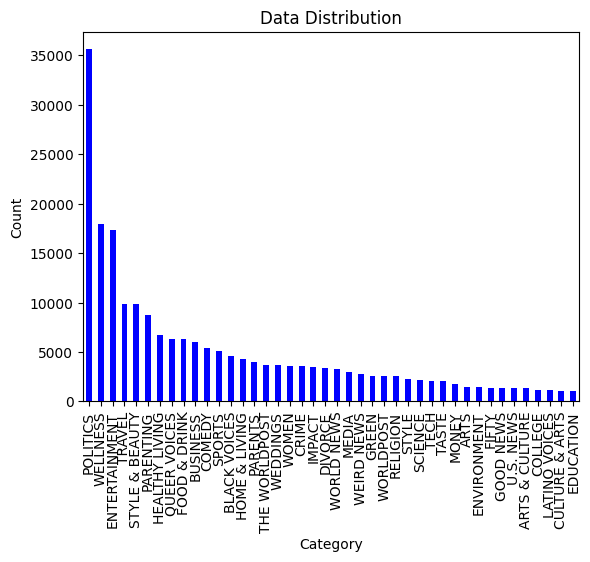

In [45]:
df['category'].value_counts().plot(kind='bar',title='Data Distribution', color='blue', ylabel='Count', xlabel='Category')

## 2. Define a classification pipeline.
Include pre-processing steps and feature engineering, possibly using stemming, lemmatization, removal of particular words, and/or text augmentation with wordnet. In this step, briefly review the models and assumptions. In special, for the bag-of-words model, discuss why it makes sense to use the presence of particular words for that specific classification problem, and try to find counter-examples in which this assumption could be purposefully exploited to confuse the classifier.

In [46]:
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    tokens = word_tokenize(text.lower())
    
    processed = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    
    return ' '.join(processed)

In [47]:
df['processed_text'] = df['text'].apply(preprocess)

In [48]:
df.head(10)

,headline,category,short_description,text,processed_text
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...,4 million american roll sleeve covid booster h...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li...",american airline flyer charged banned life pun...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...,23 funniest tweet cat dog week dog understand ...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...,funniest tweet parent week accidentally put to...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...,woman called cop black loses lawsuit amy coope...
5,Cleaner Was Dead In Belk Bathroom For 4 Days B...,U.S. NEWS,The 63-year-old woman was seen working at the ...,Cleaner Was Dead In Belk Bathroom For 4 Days B...,cleaner dead belk bathroom 4 day body found po...
6,Reporter Gets Adorable Surprise From Her Boyfr...,U.S. NEWS,"""Who's that behind you?"" an anchor for New Yor...",Reporter Gets Adorable Surprise From Her Boyfr...,reporter get adorable surprise boyfriend live ...
7,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS,More than half a million people remained witho...,Puerto Ricans Desperate For Water After Hurric...,puerto ricans desperate water hurricane fiona ...
8,How A New Documentary Captures The Complexity ...,CULTURE & ARTS,"In ""Mija,"" director Isabel Castro combined mus...",How A New Documentary Captures The Complexity ...,new documentary capture complexity child immig...
9,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS,White House officials say the crux of the pres...,Biden At UN To Call Russian War An Affront To ...,biden un call russian war affront body charter...


(167621,) (41906,)


<AxesSubplot: title={'center': 'Train Data Distribution'}, xlabel='Category', ylabel='Percentage'>

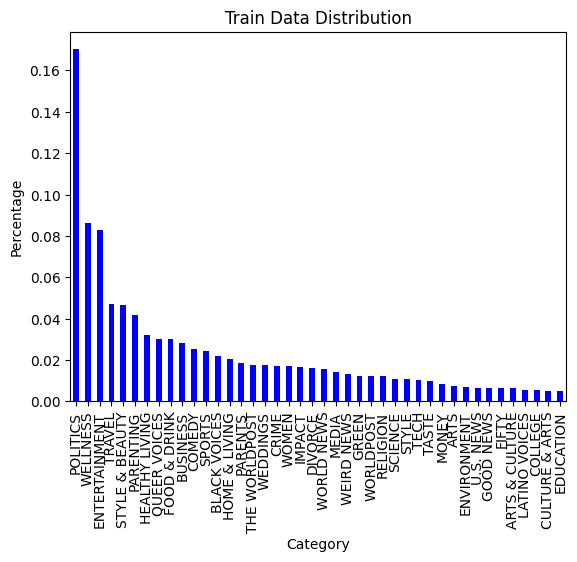

In [49]:
X = df['processed_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)

print(X_train.shape, X_test.shape)
y_train.value_counts(normalize=True).plot(kind='bar', title='Train Data Distribution', color='blue', ylabel='Percentage', xlabel='Category')

In [50]:
# Define Bag-of-Words model with Logistic Regression classifier
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(solver='saga', max_iter=1000, multi_class='multinomial'))
])

# Training takes about 7 minutes, so retraining is not recommended. Saving the model for future use
try:
    with open('models/model.pkl', 'rb') as model_file:
        pipeline = pickle.load(model_file)
except FileNotFoundError:
    pipeline.fit(X_train, y_train)
    with open('models/model.pkl', 'wb') as model_file:
        pickle.dump(pipeline, model_file)

y_pred = pipeline.predict(X_test)
accuracy_test = balanced_accuracy_score(y_test, y_pred)
y_pred_train = pipeline.predict(X_train)
accuracy_train = balanced_accuracy_score(y_train, y_pred_train)

In [51]:
print(f'Train Accuracy: {accuracy_train}')
print(f'Test Accuracy: {accuracy_test}')

Train Accuracy: 0.8725260101027574
Test Accuracy: 0.44379811996257745


In [52]:
# get top 10 important words for each category
vectorizer = pipeline.named_steps['vectorizer']
classifier = pipeline.named_steps['classifier']

words = vectorizer.get_feature_names_out()
categories = classifier.classes_

top_words = pd.DataFrame(index=categories, columns=np.arange(10))
for i, category in enumerate(categories):
    top10 = np.argsort(classifier.coef_[i])[-10:]
    top_words.loc[category] = words[top10]

display(top_words)


,0,1,2,3,4,5,6,7,8,9
ARTS,theatre,photographer,portrait,theater,painting,photography,opera,art,artist,nighter
ARTS & CULTURE,podcasts,sculpture,broadway,art,photographer,fiction,miranda,dictionary,artist,rowling
BLACK VOICES,racial,noose,rapper,racist,wiz,naacp,negro,maxine,black,mlk
BUSINESS,uber,marketer,workplace,volkswagen,startup,cnbc,chipotle,marketing,tesla,krugman
COLLEGE,campus,grad,princeton,higher,commencement,faculty,uc,college,fraternity,frat
COMEDY,fallon,kimmel,spoof,someecards,szep,oliver,trevor,colbert,conan,maher
CRIME,fugitive,oakland,murder,toddler,nypd,scammer,shooter,cop,burglar,robber
CULTURE & ARTS,nighter,2012,ballet,photo,slideshow,art,artist,poetry,exhibition,imageblog
DIVORCE,cheater,custody,stepparent,cheating,blended,breakup,divorcing,ex,divorced,divorce
EDUCATION,classroom,teaching,learning,search,charter,educational,pearson,teacher,devos,education


In [53]:
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
report_df = pd.DataFrame(report).transpose()

display(report_df)

,precision,recall,f1-score,support
ARTS,0.362319,0.255973,0.300000,293.000000
ARTS & CULTURE,0.363095,0.225926,0.278539,270.000000
BLACK VOICES,0.484605,0.388412,0.431209,932.000000
BUSINESS,0.465655,0.455825,0.460687,1279.000000
COLLEGE,0.538462,0.404444,0.461929,225.000000
COMEDY,0.498413,0.419412,0.455513,1123.000000
CRIME,0.516035,0.518302,0.517166,683.000000
CULTURE & ARTS,0.527778,0.261468,0.349693,218.000000
DIVORCE,0.800971,0.712230,0.753998,695.000000
EDUCATION,0.401408,0.331395,0.363057,172.000000


In [54]:
# top 5 most precise categories and top 5 least precise categories

report_df['precision'] = report_df['precision'].astype(float)
top5_precise = report_df.sort_values('precision', ascending=False).head(5)
least5_precise = report_df.sort_values('precision').head(5)

display(top5_precise)
display(least5_precise)

,precision,recall,f1-score,support
DIVORCE,0.800971,0.712230,0.753998,695.0
STYLE & BEAUTY,0.788354,0.781627,0.784976,1992.0
WEDDINGS,0.770468,0.720930,0.744876,731.0
QUEER VOICES,0.715501,0.596063,0.650344,1270.0
TRAVEL,0.707185,0.726859,0.716887,1977.0


,precision,recall,f1-score,support
U.S. NEWS,0.314516,0.148289,0.201550,263.0
HEALTHY LIVING,0.334818,0.341667,0.338208,1320.0
TASTE,0.339744,0.246512,0.285714,430.0
WOMEN,0.342105,0.329114,0.335484,711.0
IMPACT,0.350943,0.268786,0.304419,692.0


# 4. Assess the dataset size
Use the strategy of evaluating errors in the train and in the test datasets for various levels of dataset downsampling. According to this assessment, how much room is there to increase your accuracy by increasing the dataset size? Is it feasible given the business case?

In [64]:
fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
train_scores = []
test_scores = []

def compute_scores(frac):
    print(f'Training with {frac * 100}% of the data')

    n_samples = int(frac * len(X))
    df_sampled = df.sample(n=n_samples, random_state=23).reset_index(drop=True)
    df_sampled = df_sampled.sample(frac=1, random_state=23).reset_index(drop=True)

    X_sample = df_sampled['processed_text']
    y_sample = df_sampled['category']

    X_train, _, y_train, _ = train_test_split(X_sample, y_sample, train_size=0.2, shuffle=True, random_state=23)
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    train_score = balanced_accuracy_score(y_train, y_pred_train)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    return train_score, test_score

results = Parallel(n_jobs=5)(delayed(compute_scores)(frac) for frac in fractions)

train_scores, test_scores = zip(*results)

train_scores = list(train_scores)
test_scores = list(test_scores)

train_errors = [1 - score for score in train_scores]
test_errors = [1 - score for score in test_scores]


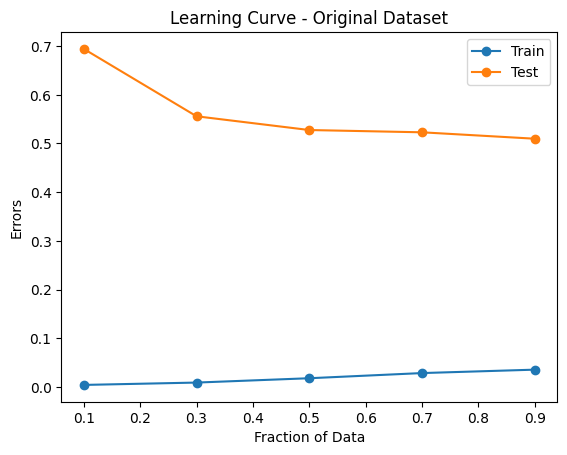

In [66]:
plt.plot(fractions, train_errors, 'o-', label='Train')
plt.plot(fractions, test_errors, 'o-', label='Test')
plt.xlabel('Fraction of Data')
plt.ylabel('Errors')
plt.title('Learning Curve - Original Dataset')
plt.legend()
plt.show()

# 5. Use topic models to refine your answers.
What does a topic analysis show? Do we have the same error rate over all dataset? Or are there some topics in which classification is more effective? Test a two-layer classifier in which documents are first classified according to their topic, and are then redirected to a classifier focused solely on that specific topic.

In [61]:
def print_words_in_topics(nmf, vectorizer):
    words = vectorizer.get_feature_names_out()
    for i, topic in enumerate(nmf.components_):
        top_words = np.argsort(topic)[-10:]
        print(f'Topic {i}: {", ".join(words[top_words])}')

n = 20

vectorizer_nmf_pipeline = Pipeline([('vectorizer', CountVectorizer(binary=True, stop_words='english')),
                                    ('nmf', NMF(n_components=n, random_state=23))])
X_nmf = vectorizer_nmf_pipeline.fit_transform(df['processed_text'])

In [62]:
print_words_in_topics(vectorizer_nmf_pipeline['nmf'], vectorizer_nmf_pipeline['vectorizer'])

Topic 0: stress, work, experience, come, matter, living, live, change, love, life
Topic 1: hillary, campaign, white, clinton, house, gop, republican, president, donald, trump
Topic 2: star, jersey, book, fashion, report, state, study, city, york, new
Topic 3: check, 2012, star, best, fashion, dress, style, home, look, photo
Topic 4: later, 20, month, million, american, old, 10, past, ago, year
Topic 5: gop, house, right, home, man, wo, expert, official, police, say
Topic 6: family, feel, right, season, holiday, spend, come, good, long, time
Topic 7: recipe, love, big, father, morning, start, wedding, valentine, mother, day
Topic 8: read, little, going, love, sound, think, really, feel, look, like
Topic 9: state, killed, country, help, study, health, million, american, think, people
Topic 10: decision, food, great, change, sense, good, sure, feel, better, make
Topic 11: instagram, tumblr, style, pinterest, sure, huffpost, facebook, check, twitter, want
Topic 12: think, change, easy, 10,

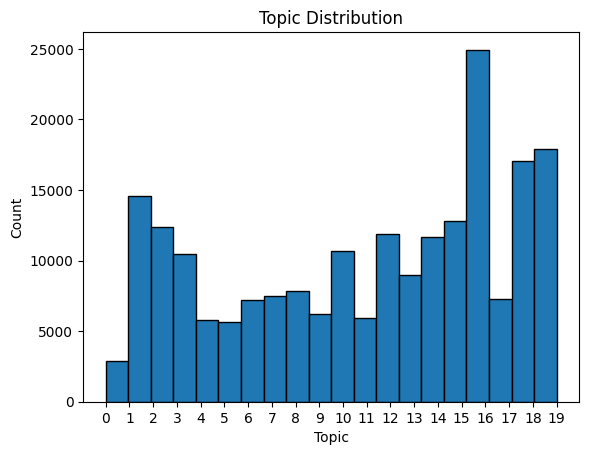

In [63]:
topic = np.argmax(X_nmf, axis=1)
plt.hist(topic, bins=len(set(topic)), edgecolor='black')
plt.title('Topic Distribution')
plt.xticks(range(n))
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_nmf, df['category'], test_size=0.2, random_state=42)

# First layer: Classify documents into topics using the NMF topic features
topic_classifier = LogisticRegression(max_iter=1000, random_state=42)
topic_classifier.fit(X_train, np.argmax(X_train, axis=1)) 

# Second layer: Train topic-specific classifiers
topic_classifiers = {}
for topic in range(n):
    topic_indices = np.argmax(X_train, axis=1) == topic
    
    if sum(topic_indices) > 0:
        classifier = LogisticRegression(max_iter=1000, random_state=42)
        classifier.fit(X_train[topic_indices], y_train[topic_indices])
        topic_classifiers[topic] = classifier

# Two-layer prediction function
def two_layer_predict(X):
    topic_predictions = topic_classifier.predict(X)
    final_predictions = []
    
    for i, topic in enumerate(topic_predictions):
        if topic in topic_classifiers:
            final_label = topic_classifiers[topic].predict(X[i].reshape(1, -1))
        else:
            final_label = np.array([None])
        final_predictions.append(final_label[0])
    
    return np.array(final_predictions)

y_pred = two_layer_predict(X_test)

# Evaluate the final model
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Two-Layer Classifier Balanced Accuracy: {balanced_accuracy:.4f}')


Two-Layer Classifier Balanced Accuracy: 0.0646


In [71]:
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df = report_df[report_df.precision != 0]

display(report_df)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
ENTERTAINMENT,0.151917,0.120503,0.134399,3419.000000
FOOD & DRINK,0.141414,0.011024,0.020453,1270.000000
HOME & LIVING,0.428571,0.003413,0.006772,879.000000
PARENTING,0.319068,0.333145,0.325955,1768.000000
POLITICS,0.277732,0.844724,0.418024,7155.000000
STYLE & BEAUTY,0.396716,0.464810,0.428072,1975.000000
TRAVEL,0.166545,0.112815,0.134513,2021.000000
WELLNESS,0.173481,0.494553,0.256860,3672.000000
WOMEN,0.179082,0.327373,0.231518,727.000000
accuracy,0.244881,0.244881,0.244881,0.244881
